In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install arff

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4950 sha256=5cc79a927e857e8dcb493083de4b4428b6b6d30ac200a20ca4d595e6b907f46b
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Data reading & preprocessing

In [ ]:
solvent_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [ ]:
nucleophile_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [ ]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.set_index('catalyst_name', inplace = True)
catalyst_columns = list(catalyst_data.columns)

In [ ]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
#r_catalyst_data.drop(17, inplace = True)

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)
catalyst_data.set_index('catalyst_name', inplace = True)

catalyst_columns = list(catalyst_data.columns)

# catalyst_data

In [ ]:
iminium_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [ ]:
class Reaction():

    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium_type, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium_type = iminium_type
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G

        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]

        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]

        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]

        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)

        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]



    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [ ]:
reactions = dict()

def process_data(reaction_number, reaction, iminium_type, sheetname = None):
    reaction_file = '/content/drive/My Drive/Colab Notebooks/material_project/data/reaction information/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)

    data.set_index('entry', inplace = True)

    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)


        reactions[reaction_name] = Reaction(reaction_name,
                                            entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            iminium_type,
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])



In [ ]:
process_data(1, 'Addition of Alcohols', 'E', 'Scope')
process_data(2, 'Addition of thiols', 'E', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'E', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'E', 'Imine scope')
process_data(2, 'Addition of thiols', 'E', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'E', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'E', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Solvent screening data')
#process_data(7, 'Peroxidation of imines', 'E', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'E', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Imine scope')
#process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Z', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Imine scope')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Catalyst screening data')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Imine scope')
#process_data(18, 'Addition of enecarbamates to benzoyl imines')
#process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
#process_data(20, 'Addition of thiols to imines (Denmark)')

In [ ]:
print(len(reactions))

342


In [ ]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]

#first column is numerical

In [ ]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]

#first column is numerical

In [ ]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]

#first column is numerical

In [ ]:
iminium = pd.DataFrame(columns = ['Reaction', "iminium_type"] + iminium_columns)
iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    if reactions[reaction].iminium_type == 'E':
        iminium.loc[reaction, "iminium_type"] = 'E'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
    elif reactions[reaction].iminium_type == 'Z':
        iminium.loc[reaction, "iminium_type"] = 'Z'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]



In [ ]:
ee = pd.DataFrame(columns = ['Reaction', 'ee'])
ee.set_index('Reaction', inplace = True)

for reaction in reactions:
    ee.loc[reaction, 'ee'] = reactions[reaction].ee

In [ ]:
Y = pd.DataFrame(columns = ['Reaction', 'ΔΔG‡'])
Y.set_index('Reaction', inplace = True)

for reaction in reactions:
    Y.loc[reaction, 'ΔΔG‡'] = reactions[reaction].G


In [ ]:
print(catalyst.shape, nucleophile.shape, solvent.shape, iminium.shape, ee.shape)

(342, 85) (342, 15) (342, 160) (342, 22) (342, 1)


In [ ]:
print(np.mean(np.array(Y.values)))
print(np.mean(np.std(Y.values)))
z=(np.array(Y.values) -np.mean(np.array(Y.values))) / np.mean(np.std(Y.values))

1.5760306524767143
0.802152536879301


In [ ]:
np.sort(np.array(z), axis=0)

array([[-2.7955337721869644],
       [-2.4217088065954164],
       [-2.310495712044731],
       [-2.172806252748415],
       [-2.0831121609312566],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.964751814671201],
       [-1.9499878960523969],
       [-1.9499878960523969],
       [-1.9499878960523969],
       [-1.7902871448013835],
       [-1.7867328999516887],
       [-1.732261452658744],
       [-1.65757713261384],
       [-1.6500378645112281],
       [-1.6190079172976712],
       [-1.6190079172976712],
       [-1.6074666498445496],
       [-1.6074666498445496],
       [-1.5819243934386555],
       [-1.5819243934386555],
       [-1.5718846247437606],
       [-1.5718846247437606],
       [-1.507794822767859],
       [-1.5029543192305757],
       [-1.491516956456488],
       [-1.4751270441677733],
       [-1.441989913001007],
       [-1.44198991300100

In [ ]:
from scipy import stats
res = stats.shapiro(np.array(Y.values))
res.statistic

0.9844329953193665

(array([ 1.,  0.,  2.,  1.,  1., 10.,  4., 12.,  9., 17., 11.,  6., 12.,
        14., 14., 20., 19., 23., 26., 23., 28., 15., 11., 27.,  6., 11.,
         2.,  8.,  8.,  1.]),
 array([-0.66641385, -0.53529915, -0.40418444, -0.27306974, -0.14195503,
        -0.01084033,  0.12027438,  0.25138908,  0.38250379,  0.5136185 ,
         0.6447332 ,  0.77584791,  0.90696261,  1.03807732,  1.16919202,
         1.30030673,  1.43142144,  1.56253614,  1.69365085,  1.82476555,
         1.95588026,  2.08699496,  2.21810967,  2.34922437,  2.48033908,
         2.61145379,  2.74256849,  2.8736832 ,  3.0047979 ,  3.13591261,
         3.26702731]),
 <BarContainer object of 30 artists>)

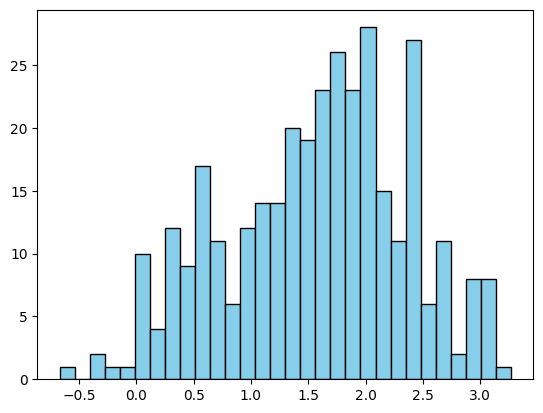

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(np.array(Y.values), bins=30, color='skyblue', edgecolor='black')